# Notebook for merging the data sets of the tree cadastre and the watering data

In [2]:
import pandas as pd
import geopandas as gpd

df_water = pd.read_csv("data/cleaned_bewaesserungsdaten.csv")

gdf_trees = gpd.read_file("data/berlin_strassenbaeume.geojson")


In [3]:
# normalize column names
df_water.columns = df_water.columns.str.lower().str.replace(" ", "_")
gdf_trees.columns = gdf_trees.columns.str.lower().str.replace(" ", "_")

df_water["date"] = pd.to_datetime(df_water["date"]).dt.normalize()
df_water["bewaesserungsmenge_in_liter"] = pd.to_numeric(
    df_water["bewaesserungsmenge_in_liter"], errors="coerce"
)

df_water = df_water.loc[df_water['year']==2022.0]
df_water.head()

,id,lng,lat,bezirk,art_dtsch,gattung_deutsch,strname,pflanzjahr,bewaesserungsmenge_in_liter,date,year,month
7,00008100:00183e6e,13.42510,52.53376,Pankow,Baum-Hasel,HASEL,Winsstraße,1993.0,50.0,2022-08-23,2022.0,8.0
11,00008100:00143152,13.34304,52.47597,Tempelhof-Schöneberg,Robinie,ROBINIE,Rubensstraße,2011.0,10.0,2022-06-05,2022.0,6.0
17,00008100:000c3e79,13.30421,52.51563,Charlottenburg-Wilmersdorf,Birken-Pappel,PAPPEL,Haubachstraße,1984.0,30.0,2022-06-12,2022.0,6.0
19,00008100:00100a35,13.29507,52.42922,Steglitz-Zehlendorf,Hängende Silber-Linde,LINDE,Altdorfer Straße,2004.0,100.0,2022-06-27,2022.0,6.0
37,00008100:00195b30,13.40229,52.55131,Pankow,Linde,LINDE,Behmstraße,2009.0,20.0,2022-07-03,2022.0,7.0


In [4]:
df_water_agg = df_water.groupby('id').agg(
    total_volume=('bewaesserungsmenge_in_liter', 'sum'),
    events=('bewaesserungsmenge_in_liter', 'count'),
    last_watered=('date', 'max')
).reset_index()
df_water_agg.head()


,id,total_volume,events,last_watered
0,00008100:000bbc0f,630.0,7,2022-08-10
1,00008100:000bbc3e,275.0,4,2022-06-12
2,00008100:000bbc40,680.0,7,2022-08-10
3,00008100:000bbc41,680.0,7,2022-08-10
4,00008100:000bbc74,60.0,3,2022-06-23


In [5]:
df_water_agg.describe(include='all')


,id,total_volume,events,last_watered
count,3835,3835.00000,3835.000000,3835
unique,3835,NaN,NaN,NaN
top,00008100:000bbc0f,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,194.56193,4.288136,2022-07-21 09:05:57.653194240
min,NaN,1.00000,1.000000,2022-04-02 00:00:00
25%,NaN,35.00000,1.000000,2022-06-25 00:00:00
50%,NaN,90.00000,2.000000,2022-08-04 00:00:00
75%,NaN,220.00000,5.000000,2022-08-14 00:00:00
max,NaN,3146.00000,178.000000,2022-12-15 00:00:00


In [6]:
df_water_agg.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3835 entries, 0 to 3834
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            3835 non-null   object        
 1   total_volume  3835 non-null   float64       
 2   events        3835 non-null   int64         
 3   last_watered  3835 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 120.0+ KB


In [7]:

# merge to keep all trees
gdf_merged = gdf_trees.merge(
    df_water_agg,
    left_on="pitid",
    right_on="id",
    how="left"
)

# add flag for trees with watering
gdf_merged['has_watering'] = gdf_merged['events'].fillna(0) > 0

In [8]:
gdf_merged.to_file(
    "data/berlin_trees_with_watering_2022.gpkg",
    layer="trees_watering",
    driver="GPKG"
)

In [9]:
gdf_merged[gdf_merged['has_watering']==True].head(20)

,id_x,gisid,pitid,standortnr,kennzeich,namenr,art_dtsch,art_bot,gattung_deutsch,gattung,...,stammumfg,baumhoehe,eigentuemer,bezirk,geometry,id_y,total_volume,events,last_watered,has_watering
234,strassenbaeume.00008100_000bbc0f,00008100_000bbc0f,00008100:000bbc0f,58,01381,Friedelstraße,Kleinkronige Winter-Linde,Tilia cordata 'Rancho',LINDE,TILIA,...,36.0,7.0,Land Berlin,Neukölln,POINT (13.42779 52.48857),00008100:000bbc0f,630.0,7.0,2022-08-10,True
273,strassenbaeume.00008100_000bbc3e,00008100_000bbc3e,00008100:000bbc3e,15,01381,Friedelstraße,Winter-Linde,Tilia cordata,LINDE,TILIA,...,135.0,16.0,Land Berlin,Neukölln,POINT (13.42792 52.48887),00008100:000bbc3e,275.0,4.0,2022-06-12,True
275,strassenbaeume.00008100_000bbc40,00008100_000bbc40,00008100:000bbc40,13,01381,Friedelstraße,Winter-Linde,Tilia cordata,LINDE,TILIA,...,142.0,16.0,Land Berlin,Neukölln,POINT (13.42797 52.48862),00008100:000bbc40,680.0,7.0,2022-08-10,True
276,strassenbaeume.00008100_000bbc41,00008100_000bbc41,00008100:000bbc41,12,01381,Friedelstraße,Berg-Ulme,Ulmus glabra,ULME,ULMUS,...,240.0,18.0,Land Berlin,Neukölln,POINT (13.42799 52.48851),00008100:000bbc41,680.0,7.0,2022-08-10,True
320,strassenbaeume.00008100_000bbc74,00008100_000bbc74,00008100:000bbc74,1,01355,Franz-Körner-Straße,Dreidorniger Lederhülsenbaum,Gleditsia triacanthos,GLEDITSCHIE,GLEDITSIA,...,109.0,15.0,Land Berlin,Neukölln,POINT (13.44759 52.45725),00008100:000bbc74,60.0,3.0,2022-06-23,True
350,strassenbaeume.00008100_000bbc97,00008100_000bbc97,00008100:000bbc97,24,01328,Fontanestraße,Winter-Linde,Tilia cordata,LINDE,TILIA,...,87.0,18.0,Land Berlin,Neukölln,POINT (13.42144 52.47953),00008100:000bbc97,40.0,1.0,2022-06-12,True
508,strassenbaeume.00008100_000bbd4d,00008100_000bbd4d,00008100:000bbd4d,17,01185,Erlanger Straße,Winter-Linde,Tilia cordata,LINDE,TILIA,...,76.0,16.0,Land Berlin,Neukölln,POINT (13.43007 52.48204),00008100:000bbd4d,660.0,10.0,2022-09-06,True
509,strassenbaeume.00008100_000bbd4e,00008100_000bbd4e,00008100:000bbd4e,16,01185,Erlanger Straße,Winter-Linde,Tilia cordata,LINDE,TILIA,...,179.0,21.0,Land Berlin,Neukölln,POINT (13.42998 52.48207),00008100:000bbd4e,640.0,10.0,2022-09-06,True
513,strassenbaeume.00008100_000bbd52,00008100_000bbd52,00008100:000bbd52,12,01185,Erlanger Straße,Winter-Linde,Tilia cordata,LINDE,TILIA,...,93.0,14.0,Land Berlin,Neukölln,POINT (13.42925 52.48242),00008100:000bbd52,200.0,4.0,2022-08-17,True
515,strassenbaeume.00008100_000bbd54,00008100_000bbd54,00008100:000bbd54,10,01185,Erlanger Straße,Winter-Linde,Tilia cordata,LINDE,TILIA,...,90.0,16.0,Land Berlin,Neukölln,POINT (13.4296 52.48232),00008100:000bbd54,50.0,1.0,2022-08-17,True


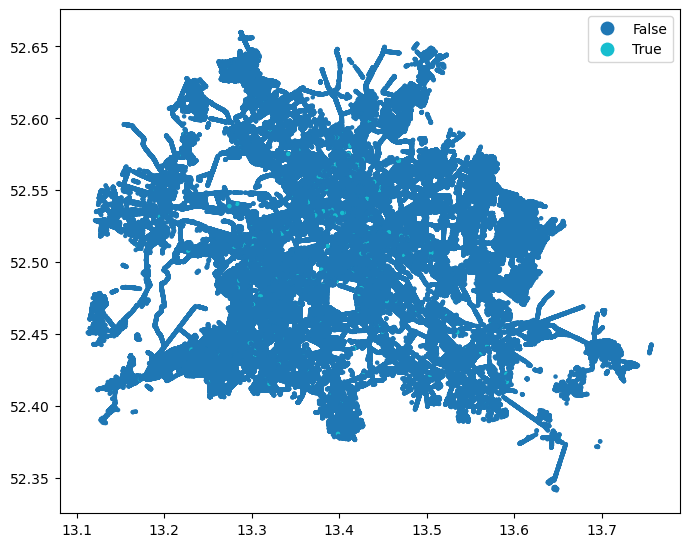

In [10]:
ax = gdf_merged.plot(
    column='has_watering',
    legend=True,
    figsize=(8,8),
    markersize=5
)

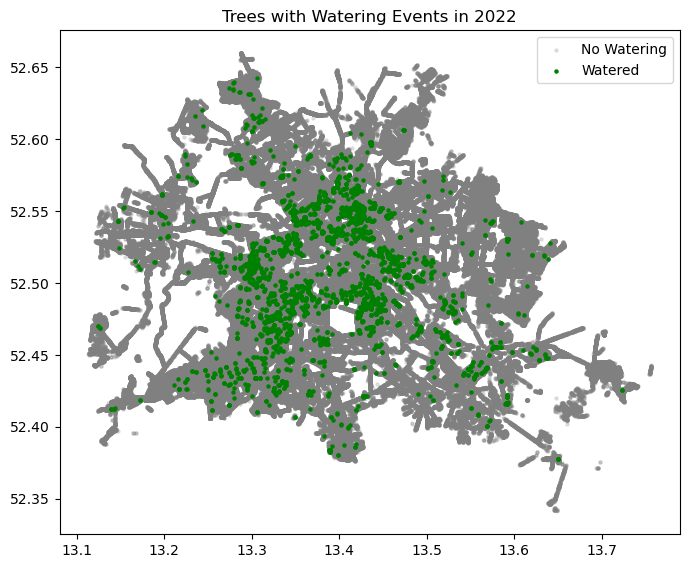

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot false points first (transparent)
gdf_merged[gdf_merged['has_watering'] == False].plot(
    ax=ax,
    color='grey',
    alpha=0.2,
    markersize=5,
    zorder=1,
    label='No Watering'
)

# Plot true points on top (solid color)
gdf_merged[gdf_merged['has_watering'] == True].plot(
    ax=ax,
    color='green',
    markersize=5,
    zorder=2,
    label='Watered'
)

ax.set_title("Trees with Watering Events in 2022")
ax.legend()
plt.show()
plt.savefig("output/trees_with_watering_2022.png")


## Get the time series of watering for each tree

In [4]:
df_water_2022 = df_water[
    df_water["month"].between(3, 9)
]

water_monthly = (
    df_water_2022
    .groupby(["id", "month"], as_index=False)
    .agg({
        "bewaesserungsmenge_in_liter": "sum"
    })
)

water_monthly.head()


,id,month,bewaesserungsmenge_in_liter
0,00008100:000bbc0f,5.0,160.0
1,00008100:000bbc0f,6.0,100.0
2,00008100:000bbc0f,7.0,280.0
3,00008100:000bbc0f,8.0,90.0
4,00008100:000bbc3e,5.0,195.0


In [5]:
water_wide = (
    water_monthly
    .pivot(
        index="id",
        columns="month",
        values="bewaesserungsmenge_in_liter"
    )
)

# fill missing months with 0
water_wide = water_wide.fillna(0)

# rename cols
water_wide.columns = [f"water_m{int(m)}" for m in water_wide.columns]
water_wide = water_wide.reset_index()
water_wide.head(5)


,id,water_m3,water_m4,water_m5,water_m6,water_m7,water_m8,water_m9
0,00008100:000bbc0f,0.0,0.0,160.0,100.0,280.0,90.0,0.0
1,00008100:000bbc3e,0.0,0.0,195.0,80.0,0.0,0.0,0.0
2,00008100:000bbc40,0.0,0.0,200.0,100.0,280.0,100.0,0.0
3,00008100:000bbc41,0.0,0.0,200.0,100.0,280.0,100.0,0.0
4,00008100:000bbc74,0.0,0.0,0.0,60.0,0.0,0.0,0.0


In [6]:
for m in range(3, 10):
    col = f"water_m{m}"
    if col not in water_wide.columns:
        water_wide[col] = 0

water_wide = water_wide.sort_index(axis=1)
water_wide.head(5)


,id,water_m3,water_m4,water_m5,water_m6,water_m7,water_m8,water_m9
0,00008100:000bbc0f,0.0,0.0,160.0,100.0,280.0,90.0,0.0
1,00008100:000bbc3e,0.0,0.0,195.0,80.0,0.0,0.0,0.0
2,00008100:000bbc40,0.0,0.0,200.0,100.0,280.0,100.0,0.0
3,00008100:000bbc41,0.0,0.0,200.0,100.0,280.0,100.0,0.0
4,00008100:000bbc74,0.0,0.0,0.0,60.0,0.0,0.0,0.0


In [7]:
water_wide.to_csv("data/timeseries/watering_2022.csv", index=False)